# Basic Settings

In [1]:
### 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab의 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats

# 천안시 출산율 현황 분석

## 분석 목적 : 천안시 출산율 현황 점검 및 타 지역구 대비 심각성 정도 확인

## 분석 방향
1. 전국 각 도 대비 충청남도 출산율 비교 분석
2. 충청남도 내 천안시 출산율 비교 분석

## 주요 용어 정리
- 합계출산율 : 한 여자가 가임기간(15~49세)에 낳을 것으로 기대되는 평균 출생아 수를 말함. 2022년 기준 0.778명 (출처: KOSIS)

### data 불러오기

In [4]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 출산율 data 불러오기

# CSV 파일 경로 지정
file_path01 = '/content/drive/MyDrive/천안 공공데이터 활용 정책제안 공모전/dataset/시도_합계출산율__모의_연령별_출산율_20240721154855.csv'
file_path02 = '/content/drive/MyDrive/천안 공공데이터 활용 정책제안 공모전/dataset/충청남도_출산율.xlsx'
xls = pd.ExcelFile(file_path02)

# CSV 파일을 DataFrame으로 읽어오기
df_birthrate_CCND_age = pd.read_csv(file_path01, encoding='euc-kr')
df_birthrate_CCND = pd.read_excel(file_path02, sheet_name=xls.sheet_names[0])
df_birthrate_CC = pd.read_excel(file_path02, sheet_name=xls.sheet_names[1])

### data 전처리

|dataset명|설명|전처리 필요한 부분|
|--|--|--|
|df_birthrate_CCND_age|시도별 합계출산율 모의연령별 data|1) column name 수정 필요<br>2) 첫번째 행에서 '모의 연령별출산율' text 제거|
|df_birthrate_CCND|시도별 합계출산율 data|X|
|df_birthrate_CC|충청남도 내 시군별 합계출산율 data|충청남도 행 제거 필요|

#### df_birthrate_CCND_age DataFrame 전처리

In [6]:
df_birthrate_CCND_age.head()

,시도별,2012,2012.1,2012.2,2012.3,2012.4,2012.5,2012.6,2012.7,2013,...,2021.6,2021.7,2022,2022.1,2022.2,2022.3,2022.4,2022.5,2022.6,2022.7
0,시도별,합계출산율,모의 연령별출산율:15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세,합계출산율,...,40-44세,45-49세,합계출산율,모의 연령별출산율:15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세
1,전국,1.297,1.8,16.0,77.4,121.9,39.0,4.9,0.2,1.187,...,7.6,0.2,0.778,0.4,4.1,24.0,73.5,44.1,8.0,0.2
2,서울특별시,1.059,1.2,7.9,49.2,108.0,42.0,5.4,0.2,0.968,...,8.3,0.2,0.593,0.2,1.4,9.9,53.5,43.4,8.7,0.2
3,부산광역시,1.135,1.6,11.1,59.0,113.9,38.0,4.6,0.2,1.049,...,7.2,0.1,0.723,0.3,3.0,19.2,70.5,42.3,7.6,0.1
4,대구광역시,1.217,1.1,12.4,70.0,122.0,35.5,3.8,0.1,1.127,...,6.3,0.1,0.757,0.2,3.3,23.6,75.4,39.7,6.9,0.1


In [7]:
# 열 이름에서 연도만 남기기
def extract_year(column_name):
    # "시도별"을 제외하고 나머지 열 이름에서 연도만 추출
    if column_name != '시도별':
        return column_name.split('.')[0]
    return column_name

In [8]:
# 열 이름을 연도만 남기도록 수정
df_birthrate_CCND_age.columns = [extract_year(col) for col in df_birthrate_CCND_age.columns]

In [9]:
df_birthrate_CCND_age.head()

,시도별,2012,2012,2012,2012,2012,2012,2012,2012,2013,...,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022
0,시도별,합계출산율,모의 연령별출산율:15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세,합계출산율,...,40-44세,45-49세,합계출산율,모의 연령별출산율:15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세
1,전국,1.297,1.8,16.0,77.4,121.9,39.0,4.9,0.2,1.187,...,7.6,0.2,0.778,0.4,4.1,24.0,73.5,44.1,8.0,0.2
2,서울특별시,1.059,1.2,7.9,49.2,108.0,42.0,5.4,0.2,0.968,...,8.3,0.2,0.593,0.2,1.4,9.9,53.5,43.4,8.7,0.2
3,부산광역시,1.135,1.6,11.1,59.0,113.9,38.0,4.6,0.2,1.049,...,7.2,0.1,0.723,0.3,3.0,19.2,70.5,42.3,7.6,0.1
4,대구광역시,1.217,1.1,12.4,70.0,122.0,35.5,3.8,0.1,1.127,...,6.3,0.1,0.757,0.2,3.3,23.6,75.4,39.7,6.9,0.1


In [10]:
# 첫번째 행에서 text 수정하기
def modify_text(text):
    # "시도별"을 제외하고 나머지 열 이름에서 연도만 추출
    if text == '모의 연령별출산율:15-19세':
        return text.split(':')[1]
    return text

In [11]:
# text 수정
df_birthrate_CCND_age.iloc[0, :] = df_birthrate_CCND_age.iloc[0, :].apply(modify_text)

In [12]:
df_birthrate_CCND_age.head()

,시도별,2012,2012,2012,2012,2012,2012,2012,2012,2013,...,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022
0,시도별,합계출산율,15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세,합계출산율,...,40-44세,45-49세,합계출산율,15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세
1,전국,1.297,1.8,16.0,77.4,121.9,39.0,4.9,0.2,1.187,...,7.6,0.2,0.778,0.4,4.1,24.0,73.5,44.1,8.0,0.2
2,서울특별시,1.059,1.2,7.9,49.2,108.0,42.0,5.4,0.2,0.968,...,8.3,0.2,0.593,0.2,1.4,9.9,53.5,43.4,8.7,0.2
3,부산광역시,1.135,1.6,11.1,59.0,113.9,38.0,4.6,0.2,1.049,...,7.2,0.1,0.723,0.3,3.0,19.2,70.5,42.3,7.6,0.1
4,대구광역시,1.217,1.1,12.4,70.0,122.0,35.5,3.8,0.1,1.127,...,6.3,0.1,0.757,0.2,3.3,23.6,75.4,39.7,6.9,0.1


#### df_birthrate_CC 데이터 전처리

In [13]:
# '충청남도' 행 제거
df_birthrate_CC = df_birthrate_CC[df_birthrate_CC['구 분'] != '충청남도']
df_birthrate_CC

,구 분,2017년,2018년,2019년,2020년,2021년
1,천안시,1.16,1.10,1.02,0.98,0.94
2,공주시,1.15,1.07,1.19,1.02,0.87
3,보령시,1.17,1.03,1.10,0.99,0.96
4,아산시,1.40,1.27,1.15,0.99,0.90
5,서산시,1.52,1.47,1.31,1.26,1.18
6,논산시,1.19,1.18,1.18,0.98,0.96
7,계룡시,1.44,1.19,1.08,0.91,0.83
8,당진시,1.65,1.49,1.39,1.25,1.18
9,금산군,1.16,1.09,1.15,1.07,0.92
10,부여군,1.09,0.91,0.85,0.81,0.68


### 1. 전국 각 도 대비 충청남도 출산율 비교 분석


#### 전국 시도별 합계출산율 (2017-2021)

- 2017년부터 2021년까지 전국 대비 충청남도 합계출산율 비교(총 17개 中)
  + 결론
    * 충청남도는 다른 시도 기준으로 나름 상위권 차지
    * 출산율이 다른 시도에 비해 나쁜 편은 아니지만, 대한민국 출산율 자체가 낮은 편이기 때문에 양호하다고 단정 지을 수 없음.
    * 출산율이 감소하는 속도를 확인할 필요가 있음.(감소폭 비교)

[연도별 전국 대비 충청남도 합계출산율 순위]

|연도|순위|비고|
|--|--|--|
|2017|전국 4위||
|2018|전국 4위||
|2019|전국 4위||
|2020|전국 4위||
|2021|전국 5위||

<br>
<br>

- 2017년부터 2021년까지 전국 대비 충청남도 합계출산율 감소폭 비교
  + 결론
    * 감소폭은 특정 연도에 집중적으로 큰 폭을 보이지 않으며, 일정하게 감소하는 추세
    * 2017년 대비 2021년(5년 사이) 감소 정도는 <u>**상위 4위**</u>를 차지(인구 감소 비율을 고려하여 더 깊게 살펴볼 필요성이 있음.)
    * 누적막대그래프로 확인한 결과 하위권 도시들에 비하면 상당히 큰 폭으로 감소하고 있음.
    * 더 넓은 기간동안의 변화를 분석할 필요성이 있음

[연도별 전국 대비 충청남도 합계출산율 감소폭 순위]

|연도|순위|비고|
|--|--|--|
|2017~2017|전국 7위||
|2018~2019|전국 5위||
|2019~2020|전국 10위||
|2020~2021|전국 3위||

<br>
<br>

<u>→ 합계출산율이 감소하는 가장 큰 원인을 살펴볼 필요가 있음. </u>

|번호|가설 내용|비고|
|--|--|--|
|가설 1|가임여성의 인구가 감소하여 자연스럽게 감소하였을 것이다.|인구 분포 분석 필요|
|가설 2|출산/육아 관련 지원 정도가 타지역 대비 부족한 편이기 때문에 감소하였을 것이다.|출산장려금, 육아장려금 등 출산관련 복지정책 분석이 필요|
|가설 3|육아를 위한 인프라 부족으로 감소하였을 것이다.|육아 관련 인프라 지원 정도 분석이 필요|


In [14]:
df_birthrate_CCND

,구 분,2017년,2018년,2019년,2020년,2021년
0,전국,1.05,0.98,0.92,0.84,0.81
1,서울특별시,0.84,0.76,0.72,0.64,0.63
2,부산광역시,0.98,0.90,0.83,0.75,0.73
3,대구광역시,1.07,0.99,0.93,0.81,0.78
4,인천광역시,1.01,1.01,0.94,0.83,0.78
5,광주광역시,1.05,0.97,0.91,0.81,0.90
6,대전광역시,1.08,0.95,0.88,0.80,0.81
7,울산광역시,1.26,1.13,1.08,0.98,0.94
8,세종특별자치시,1.67,1.57,1.47,1.28,1.28
9,경기도,1.07,1.00,0.94,0.88,0.85


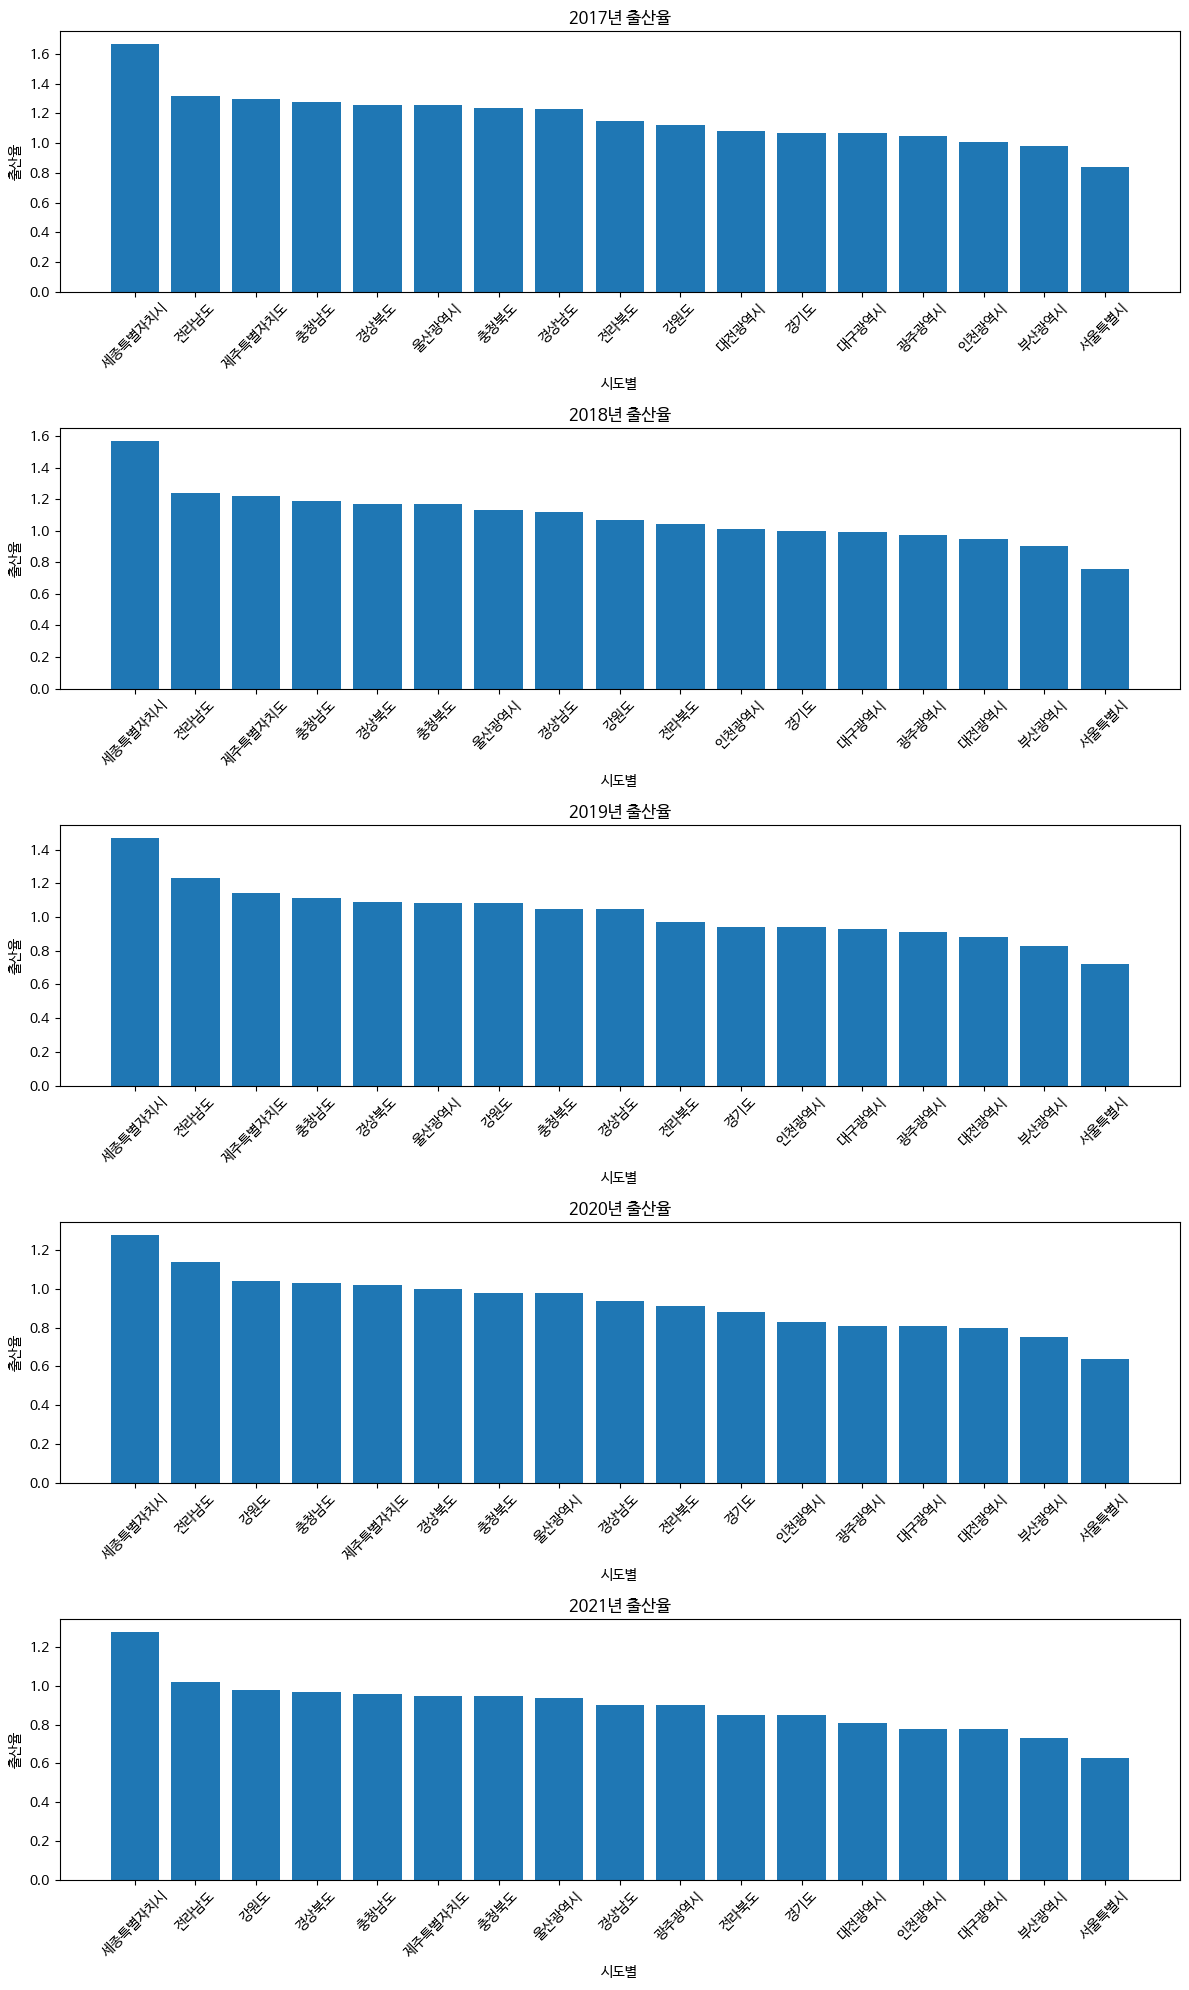

In [15]:
# 연도별 시도별 출산율 막대 그래프 그리기

# "전국" 제외
df_filtered = df_birthrate_CCND[df_birthrate_CCND['구 분'] != '전국']

# 시각화
years = ['2017년', '2018년', '2019년', '2020년', '2021년']
num_years = len(years)

fig, axs = plt.subplots(num_years, 1, figsize=(12, num_years * 4))

for i, year in enumerate(years):
    # 해당 연도 데이터 내림차순 정렬
    df_sorted = df_filtered.sort_values(by=year, ascending=False)
    axs[i].bar(df_sorted['구 분'], df_sorted[year])
    axs[i].set_title(f'{year} 출산율')
    axs[i].set_xlabel('시도별')
    axs[i].set_ylabel('출산율')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

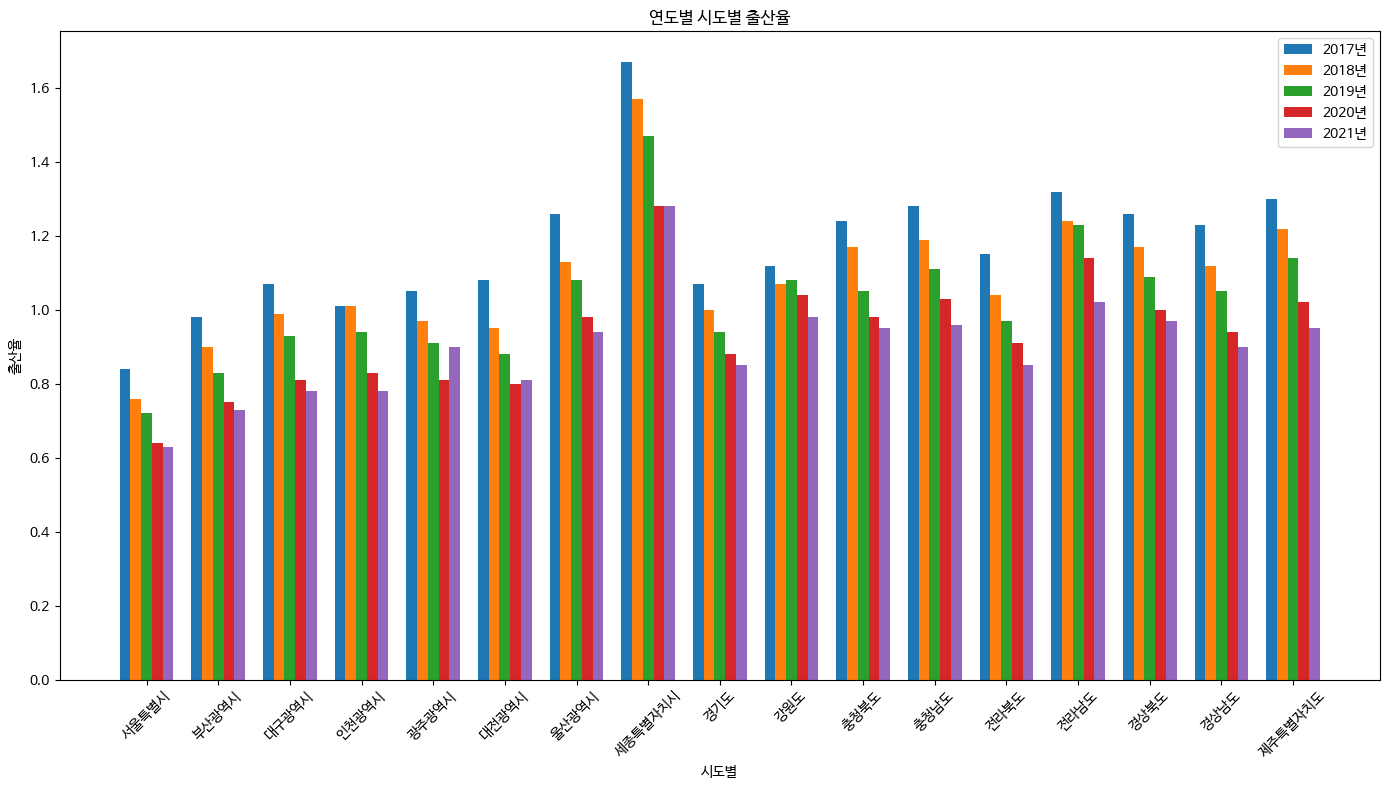

In [16]:
# 연도별 시도별 출산율 막대그래프 그리기
years = ['2017년', '2018년', '2019년', '2020년', '2021년']
x = np.arange(len(df_filtered['구 분']))  # x 위치를 위한 배열
width = 0.15  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 8))

for i, year in enumerate(years):
    ax.bar(x + i * width, df_filtered[year], width, label=year)

ax.set_xlabel('시도별')
ax.set_ylabel('출산율')
ax.set_title('연도별 시도별 출산율')
ax.set_xticks(x + width * 2)  # x축 틱 위치 조정
ax.set_xticklabels(df_filtered['구 분'], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

<ipython-input-17-012ded67a94f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['출산율 차이'] = df_filtered['2021년'] - df_filtered['2017년']
<ipython-input-17-012ded67a94f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_filtered_sorted['구 분'], rotation=45)
<ipython-input-17-012ded67a94f>:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


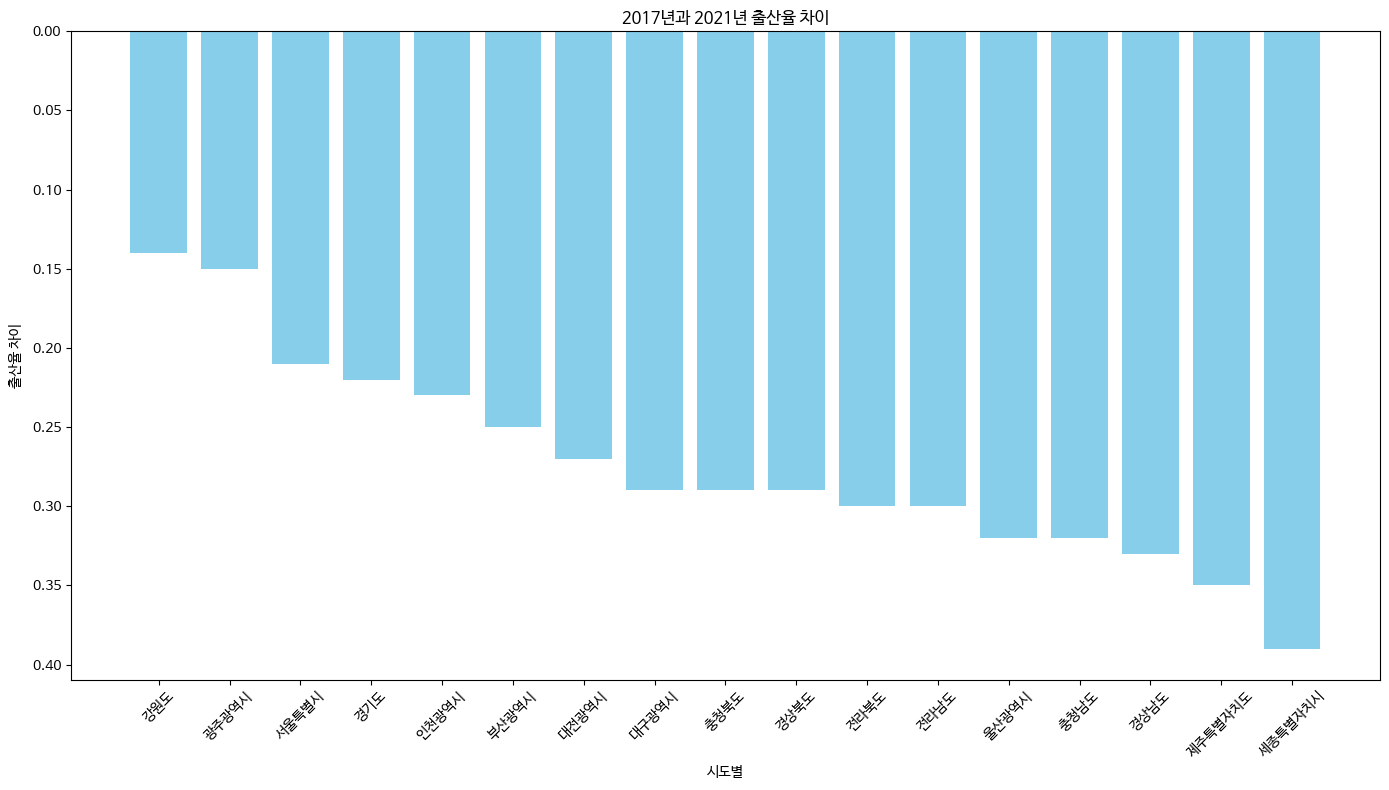

In [17]:
# 2017년 대비 2021년 출산율 감소율 그래프 그리기(5년 사이 감소율 확인)

# 2017년과 2021년 출산율 차이 계산
df_filtered['출산율 차이'] = df_filtered['2021년'] - df_filtered['2017년']

# 내림차순으로 정렬
df_filtered_sorted = df_filtered.sort_values(by='출산율 차이', ascending=False)

# 시각화
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(df_filtered_sorted['구 분'], df_filtered_sorted['출산율 차이'], color='skyblue')

ax.set_xlabel('시도별')
ax.set_ylabel('출산율 차이')
ax.set_title('2017년과 2021년 출산율 차이')
ax.set_xticklabels(df_filtered_sorted['구 분'], rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-18-9b2935e4a9c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['2017-2018'] = df_filtered['2018년'] - df_filtered['2017년']
<ipython-input-18-9b2935e4a9c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['2018-2019'] = df_filtered['2019년'] - df_filtered['2018년']
<ipython-input-18-9b2935e4a9c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

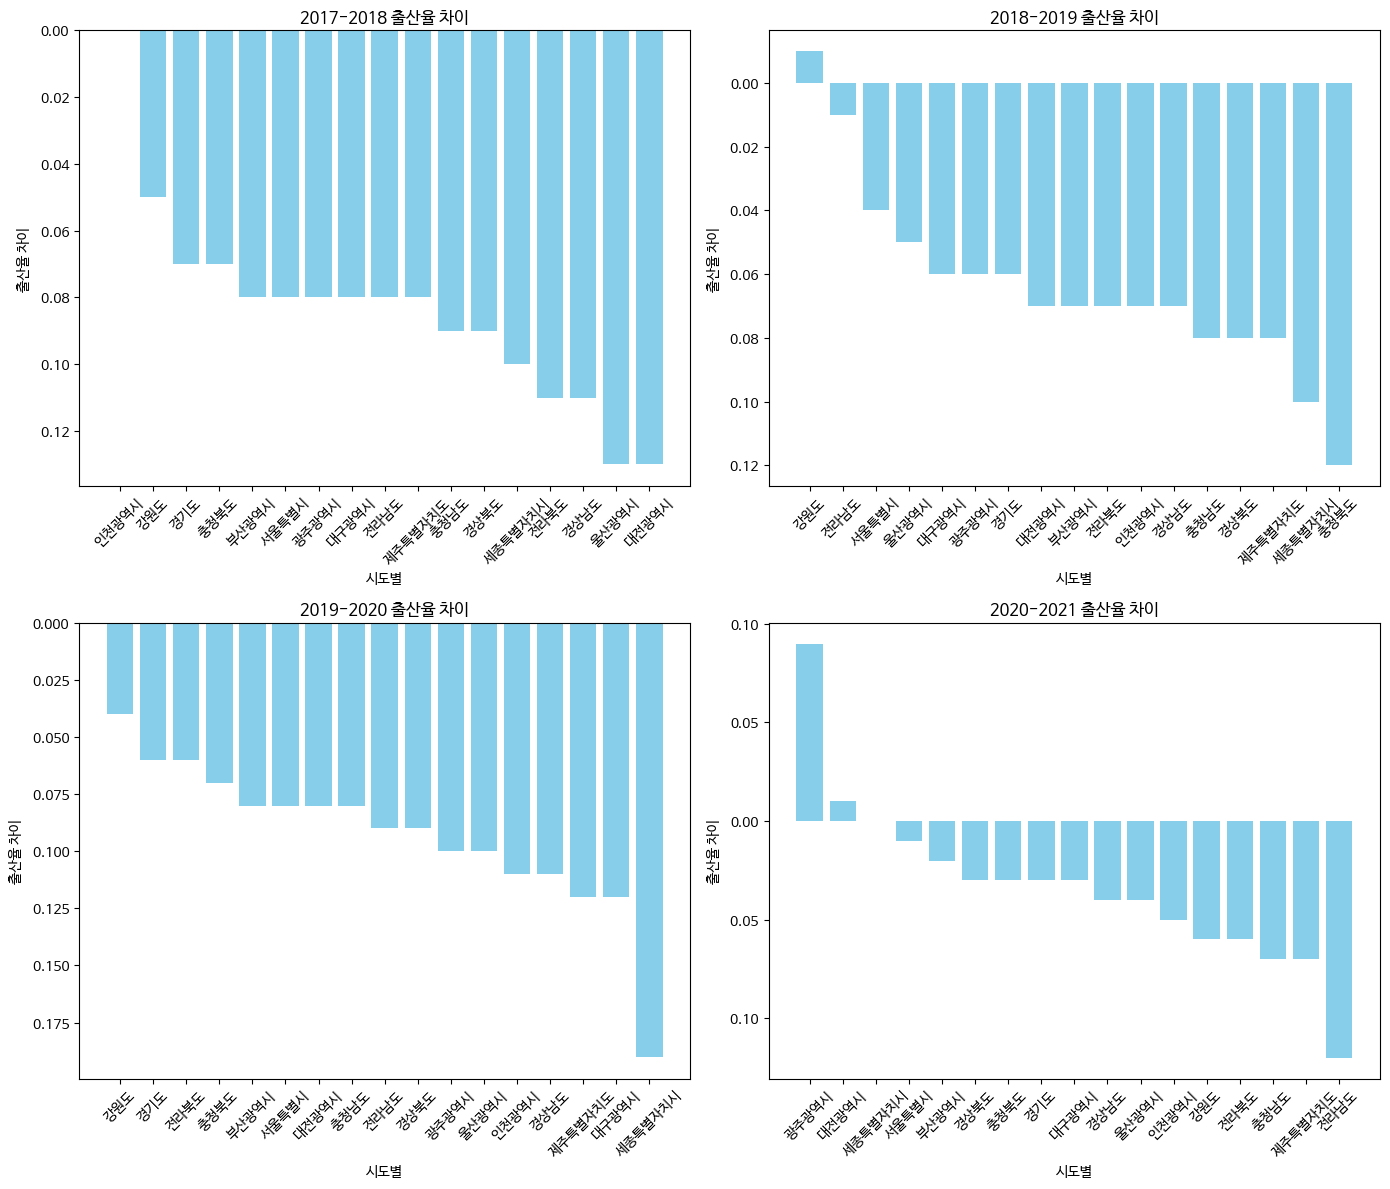

In [18]:
# 연도별 출산율 감소폭 그리기

# 출산율 차이 계산
df_filtered['2017-2018'] = df_filtered['2018년'] - df_filtered['2017년']
df_filtered['2018-2019'] = df_filtered['2019년'] - df_filtered['2018년']
df_filtered['2019-2020'] = df_filtered['2020년'] - df_filtered['2019년']
df_filtered['2020-2021'] = df_filtered['2021년'] - df_filtered['2020년']

# 시각화
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
years_diff = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']
titles = ['2017-2018 출산율 차이', '2018-2019 출산율 차이', '2019-2020 출산율 차이', '2020-2021 출산율 차이']

for ax, year_diff, title in zip(axs.flat, years_diff, titles):
    df_sorted = df_filtered.sort_values(by=year_diff, ascending=False)
    ax.bar(df_sorted['구 분'], df_sorted[year_diff], color='skyblue')
    ax.set_title(title)
    ax.set_xlabel('시도별')
    ax.set_ylabel('출산율 차이')
    ax.set_xticklabels(df_sorted['구 분'], rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-19-7ec96a1eb0f2>:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


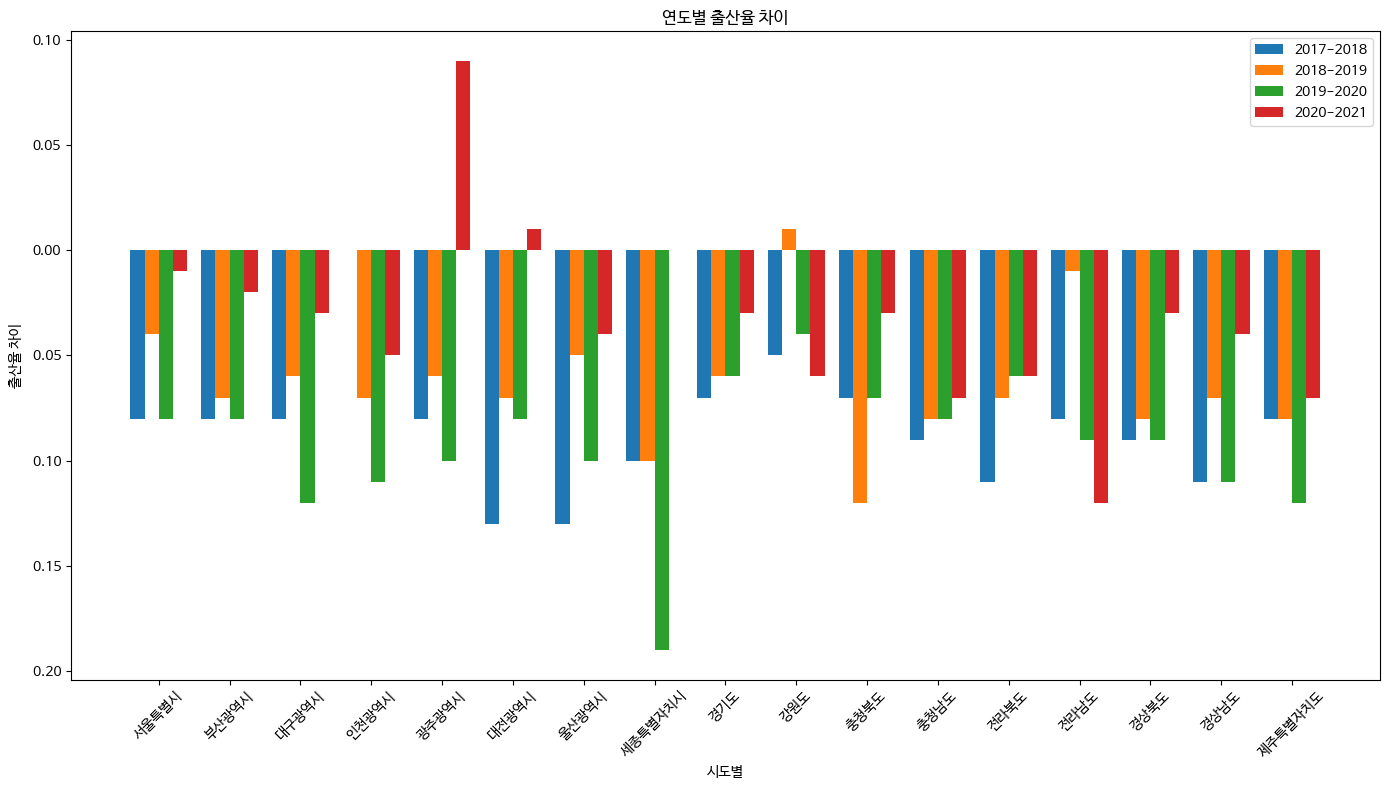

In [19]:
# 출산율 증감율 막대그래프 그리기
plt.figure(figsize=(14, 8))

years_diff = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']
bar_width = 0.2
index = np.arange(len(df_filtered['구 분']))

for i, year_diff in enumerate(years_diff):
    plt.bar(index + i * bar_width, df_filtered[year_diff], bar_width, label=year_diff)

plt.xlabel('시도별')
plt.ylabel('출산율 차이')
plt.title('연도별 출산율 차이')
plt.xticks(index + bar_width * 1.5, df_filtered['구 분'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-20-70a1f91ec437>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['총합'] = df_filtered[['2017-2018', '2018-2019', '2019-2020', '2020-2021']].sum(axis=1)
<ipython-input-20-70a1f91ec437>:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


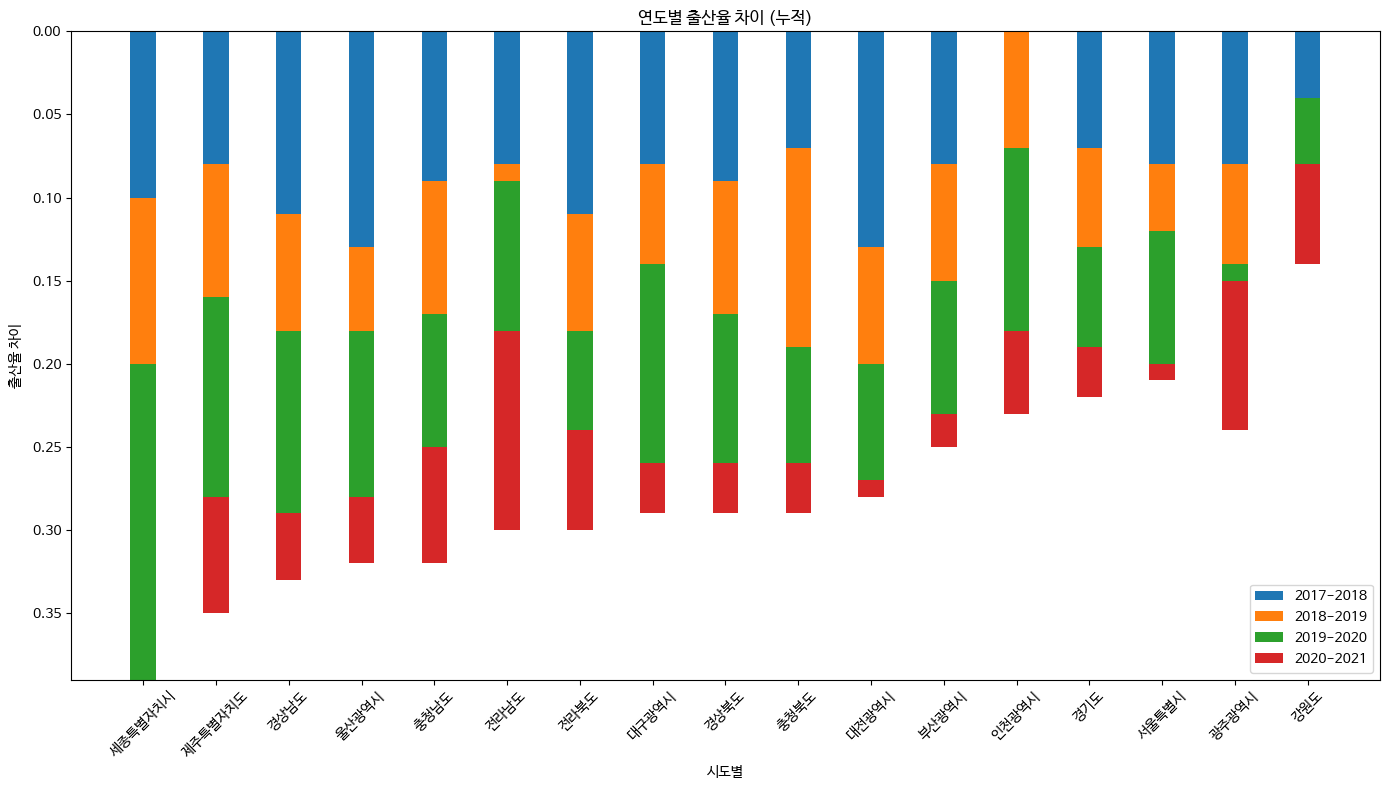

In [20]:
# 출산율 감소폭 누적 막대그래프 그리기

# 각 시도별 출산율 차이의 총합 계산
df_filtered['총합'] = df_filtered[['2017-2018', '2018-2019', '2019-2020', '2020-2021']].sum(axis=1)

# 총합을 기준으로 DataFrame 내림차순 정렬
df_filtered = df_filtered.sort_values(by='총합', ascending=True).reset_index(drop=True)

# 시각화
plt.figure(figsize=(14, 8))

years_diff = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']
bar_width = 0.35
index = np.arange(len(df_filtered['구 분']))

# 누적 막대 그래프
bottom_values = np.zeros(len(df_filtered))

for year_diff in years_diff:
    plt.bar(index, df_filtered[year_diff], bar_width, bottom=bottom_values, label=year_diff)
    bottom_values += df_filtered[year_diff]

plt.xlabel('시도별')
plt.ylabel('출산율 차이')
plt.title('연도별 출산율 차이 (누적)')
plt.xticks(index, df_filtered['구 분'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-21-55588b484032>:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


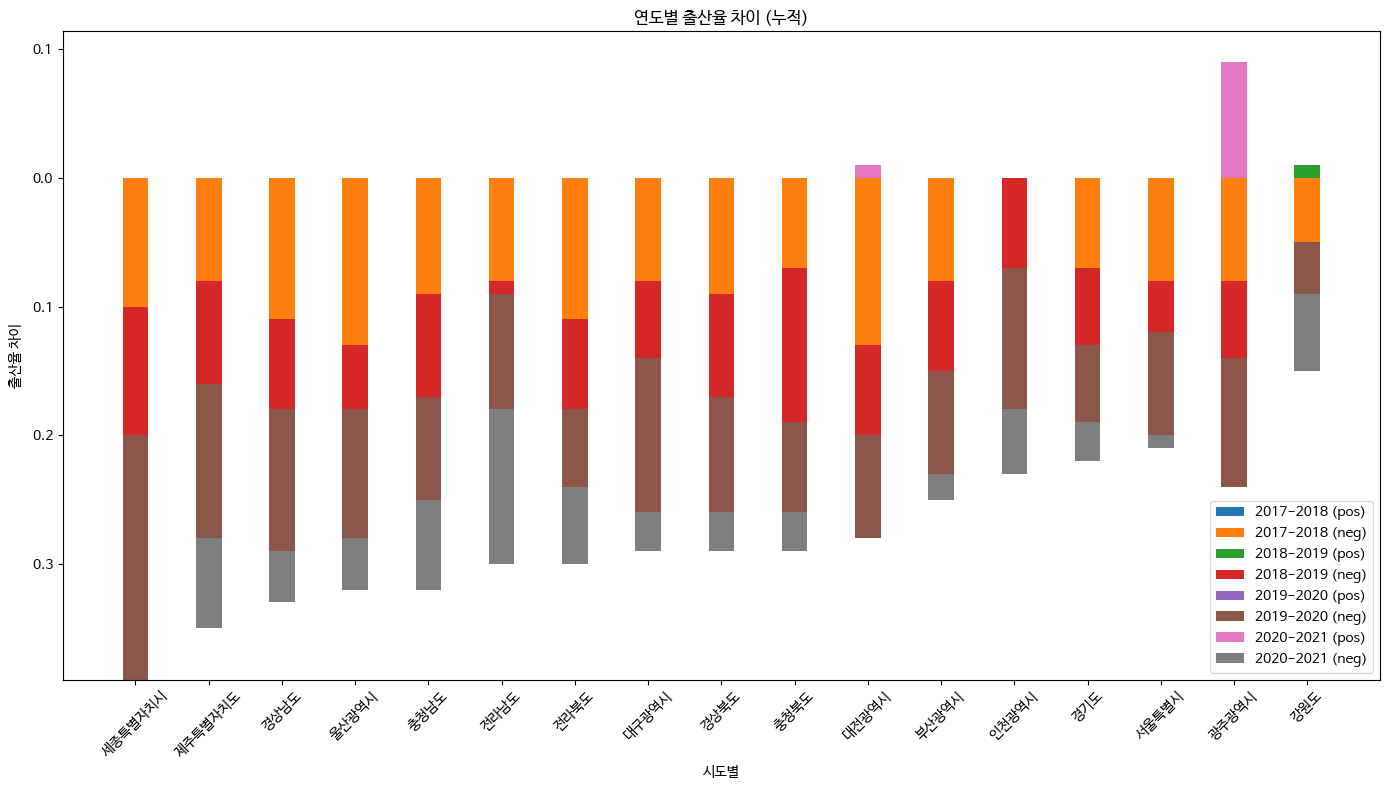

In [21]:
# 출산율 감소폭 음수와 양수로 나누어 누적 막대그래프 그리기
plt.figure(figsize=(14, 8))

years_diff = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']
bar_width = 0.35
index = np.arange(len(df_filtered['구 분']))

# 누적 막대 그래프 - 양수
bottom_values_pos = np.zeros(len(df_filtered))
bottom_values_neg = np.zeros(len(df_filtered))

for year_diff in years_diff:
    pos_diff = df_filtered[year_diff].clip(lower=0)
    neg_diff = df_filtered[year_diff].clip(upper=0)
    plt.bar(index, pos_diff, bar_width, bottom=bottom_values_pos, label=year_diff + ' (pos)')
    plt.bar(index, neg_diff, bar_width, bottom=bottom_values_neg, label=year_diff + ' (neg)')
    bottom_values_pos += pos_diff
    bottom_values_neg += neg_diff

plt.xlabel('시도별')
plt.ylabel('출산율 차이')
plt.title('연도별 출산율 차이 (누적)')
plt.xticks(index, df_filtered['구 분'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
################연령별 data 분석 중 (여기부터)

#### 전국 시도별 합계출산율 모의 연령별 data (2012-2022)

In [23]:
df_birthrate_CCND_age.head()

,시도별,2012,2012,2012,2012,2012,2012,2012,2012,2013,...,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022
0,시도별,합계출산율,15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세,합계출산율,...,40-44세,45-49세,합계출산율,15-19세,20-24세,25-29세,30-34세,35-39세,40-44세,45-49세
1,전국,1.297,1.8,16.0,77.4,121.9,39.0,4.9,0.2,1.187,...,7.6,0.2,0.778,0.4,4.1,24.0,73.5,44.1,8.0,0.2
2,서울특별시,1.059,1.2,7.9,49.2,108.0,42.0,5.4,0.2,0.968,...,8.3,0.2,0.593,0.2,1.4,9.9,53.5,43.4,8.7,0.2
3,부산광역시,1.135,1.6,11.1,59.0,113.9,38.0,4.6,0.2,1.049,...,7.2,0.1,0.723,0.3,3.0,19.2,70.5,42.3,7.6,0.1
4,대구광역시,1.217,1.1,12.4,70.0,122.0,35.5,3.8,0.1,1.127,...,6.3,0.1,0.757,0.2,3.3,23.6,75.4,39.7,6.9,0.1


In [24]:
# 데이터프레임을 긴 형태로 변환
df_long = df_birthrate_CCND_age.melt(id_vars=['시도별'], var_name='년도_연령대', value_name='합계출산율')

In [25]:
import re

def extract_year(s):
    match = re.match(r'(\d{4})', s)
    return match.group(1) if match else None

def extract_age_group(s):
    match = re.search(r'(\d{2}-\d{2}세)', s)
    return match.group(1) if match else None

df_long['연도'] = df_long['년도_연령대'].apply(extract_year)
df_long['연령대'] = df_long['년도_연령대'].apply(extract_age_group)

# 결과 확인
print(df_long.head())
print(df_long.info())
df_long

     시도별 년도_연령대  합계출산율    연도   연령대
0    시도별   2012  합계출산율  2012  None
1     전국   2012  1.297  2012  None
2  서울특별시   2012  1.059  2012  None
3  부산광역시   2012  1.135  2012  None
4  대구광역시   2012  1.217  2012  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시도별     1672 non-null   object
 1   년도_연령대  1672 non-null   object
 2   합계출산율   1672 non-null   object
 3   연도      1672 non-null   object
 4   연령대     0 non-null      object
dtypes: object(5)
memory usage: 65.4+ KB
None


,시도별,년도_연령대,합계출산율,연도,연령대
0,시도별,2012,합계출산율,2012,None
1,전국,2012,1.297,2012,None
2,서울특별시,2012,1.059,2012,None
3,부산광역시,2012,1.135,2012,None
4,대구광역시,2012,1.217,2012,None
...,...,...,...,...,...
1667,전라북도,2022,0.2,2022,None
1668,전라남도,2022,0.2,2022,None
1669,경상북도,2022,0.2,2022,None
1670,경상남도,2022,0.1,2022,None


In [26]:
# 결측값 확인
print(df_long.isnull().sum())

# 결측값 제거
df_long = df_long.dropna(subset=['연도', '연령대'])
print(df_long.head())

시도별          0
년도_연령대       0
합계출산율        0
연도           0
연령대       1672
dtype: int64
Empty DataFrame
Columns: [시도별, 년도_연령대, 합계출산율, 연도, 연령대]
Index: []


In [27]:
df_long['년도_연령대'].head(10)

,년도_연령대


In [28]:
################연령별 data 분석 중 (여기까지)

### 2. 충청남도 내 천안시 출산율 비교 분석

#### 충청남도 시군별 합계출산율 data (2017-2021)
- 충청남도 내 천안시 연도별 합계출산율 중하위권 위치
- 충청남도 시군별 평균 합계출산율 보다 낮으며, 감소폭은 평균 감소폭보다 완만한 편
- 각 연도별로 지역별 합계출산율을 비교한 결과, 매년 중하위권 위치(15개 中)

|연도|순위|비고|
|--|--|--|
|2017년|8위||
|2018년|8위||
|2019년|12위||
|2020년|10위||
|2021|8위||

- 다른 시군들에 비해 천안시의 2017년 대비 2021년(5년 기간) 합계출산율 감소 정도는 크지 않으며 비슷한 수준.
- 충청남도 전체 시군 중 감소폭 규모 11위

<br>
<br>

<u>→ 천안시는 충청남도 내에서 합계출산율이 낮은편에 속하나, 감소폭이 크지는 않은 편. 감소폭이 크지 않은 이유를 살펴볼 필요가 있음. </u>

|번호|가설 내용|비고|
|--|--|--|
|가설 1|천안시는 다른 충청남도 시군보다 출산율 장려에 영향을 주는 요인이 적을 것이다.|천안시가 타지역보다 출산/육아 관련 부족한 부분을 확인|
|가설 2|천안시의 가임여성 비중이 타지역보다 적을 것이다.|인구분포를 반영하여 분석 필요|
|가설 3|천안시가 타지역보다 출산율 감소 방어를 잘하고 있기 때문에 타지역에 비해 감소폭이 크지 않은 것이다.|출산율 감소에 영향을 주는 요인 분석|

In [29]:
df_birthrate_CC

,구 분,2017년,2018년,2019년,2020년,2021년
1,천안시,1.16,1.10,1.02,0.98,0.94
2,공주시,1.15,1.07,1.19,1.02,0.87
3,보령시,1.17,1.03,1.10,0.99,0.96
4,아산시,1.40,1.27,1.15,0.99,0.90
5,서산시,1.52,1.47,1.31,1.26,1.18
6,논산시,1.19,1.18,1.18,0.98,0.96
7,계룡시,1.44,1.19,1.08,0.91,0.83
8,당진시,1.65,1.49,1.39,1.25,1.18
9,금산군,1.16,1.09,1.15,1.07,0.92
10,부여군,1.09,0.91,0.85,0.81,0.68


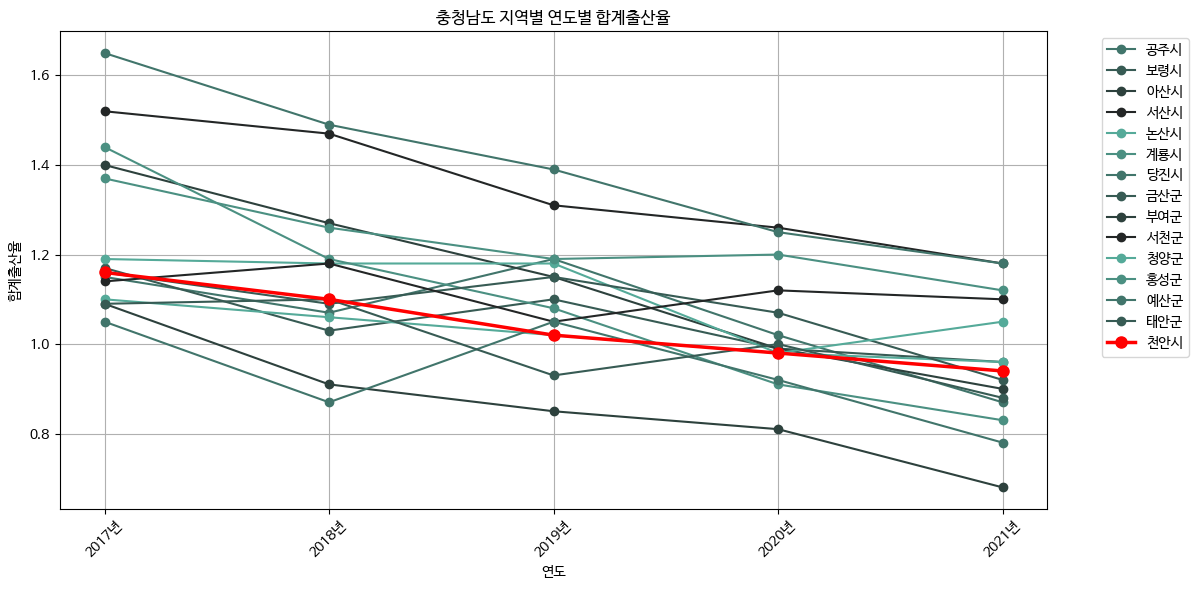

In [30]:
# 연도별 충청남도 지역별 합계출산율 변화 선그래프 그리기
# 연도별 데이터 준비
years = df_birthrate_CC.columns[1:]

# 어두운 색상 팔레트
dark_palette = sns.color_palette("dark:#5A9_r")

plt.figure(figsize=(12, 6))  # 가로 크기를 넓힌 그래프 설정

# 모든 지역 데이터 시각화 (천안시 제외)
for index, row in df_birthrate_CC.iterrows():
    if row['구 분'] != '천안시':
        # 어두운 색상 팔레트에서 색상 선택
        color = dark_palette[index % len(dark_palette)]
        plt.plot(years, row[1:], marker='o', linestyle='-', color=color, label=row['구 분'])

# 천안시 데이터 시각화 (마지막으로 그려서 가장 위에 위치하도록 함)
for index, row in df_birthrate_CC.iterrows():
    if row['구 분'] == '천안시':
        plt.plot(years, row[1:], marker='o', linestyle='-', color='red', linewidth=2.5, markersize=8, label='천안시')  # 천안시 강조

# 그래프 설정
plt.title('충청남도 지역별 연도별 합계출산율')
plt.xlabel('연도')
plt.ylabel('합계출산율')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

# 그래프 보여주기
plt.show()

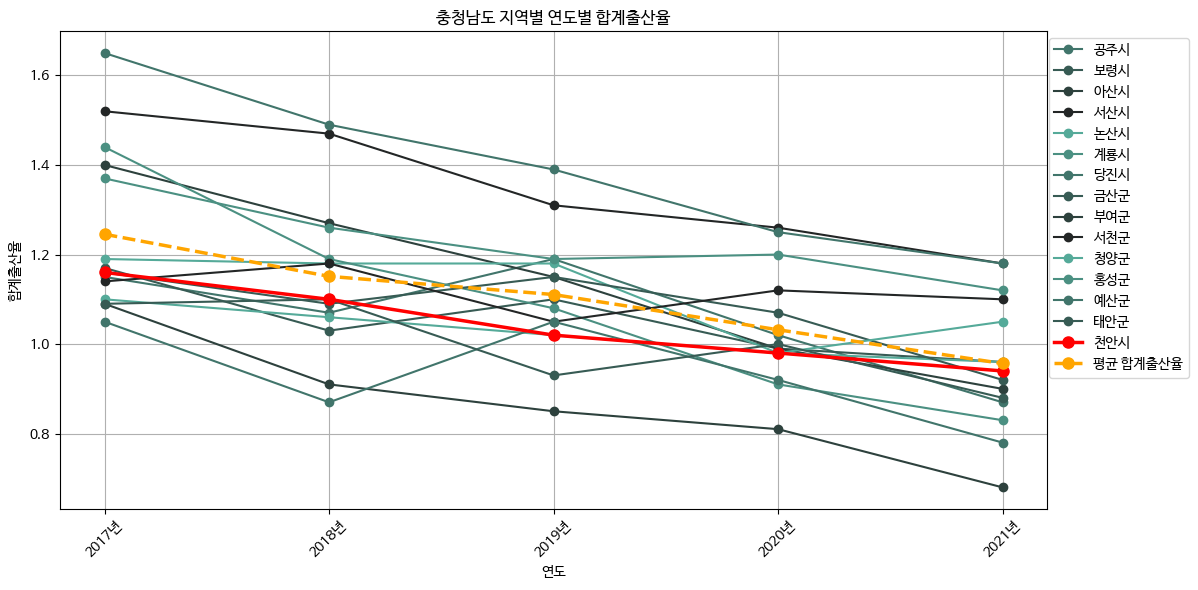

In [31]:
# 평균 합계출산율 선그래프 추가하기

# 평균 합계출산율 계산
average_birthrate = df_birthrate_CC.iloc[:, 1:].mean()

# 어두운 색상 팔레트
dark_palette = sns.color_palette("dark:#5A9_r")

plt.figure(figsize=(12, 6))  # 가로 크기를 넓힌 그래프 설정

# 모든 지역 데이터 시각화 (천안시 제외)
for index, row in df_birthrate_CC.iterrows():
    if row['구 분'] != '천안시':
        # 어두운 색상 팔레트에서 색상 선택
        color = dark_palette[index % len(dark_palette)]
        plt.plot(years, row[1:], marker='o', linestyle='-', color=color, label=row['구 분'])

# 천안시 데이터 시각화 (마지막으로 그려서 가장 위에 위치하도록 함)
for index, row in df_birthrate_CC.iterrows():
    if row['구 분'] == '천안시':
        plt.plot(years, row[1:], marker='o', linestyle='-', color='red', linewidth=2.5, markersize=8, label='천안시')  # 천안시 강조

# 평균 합계출산율 데이터 시각화
plt.plot(years, average_birthrate, marker='o', linestyle='--', color='orange', linewidth=2.5, markersize=8, label='평균 합계출산율')

# 그래프 설정
plt.title('충청남도 지역별 연도별 합계출산율')
plt.xlabel('연도')
plt.ylabel('합계출산율')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

# 그래프 보여주기
plt.show()

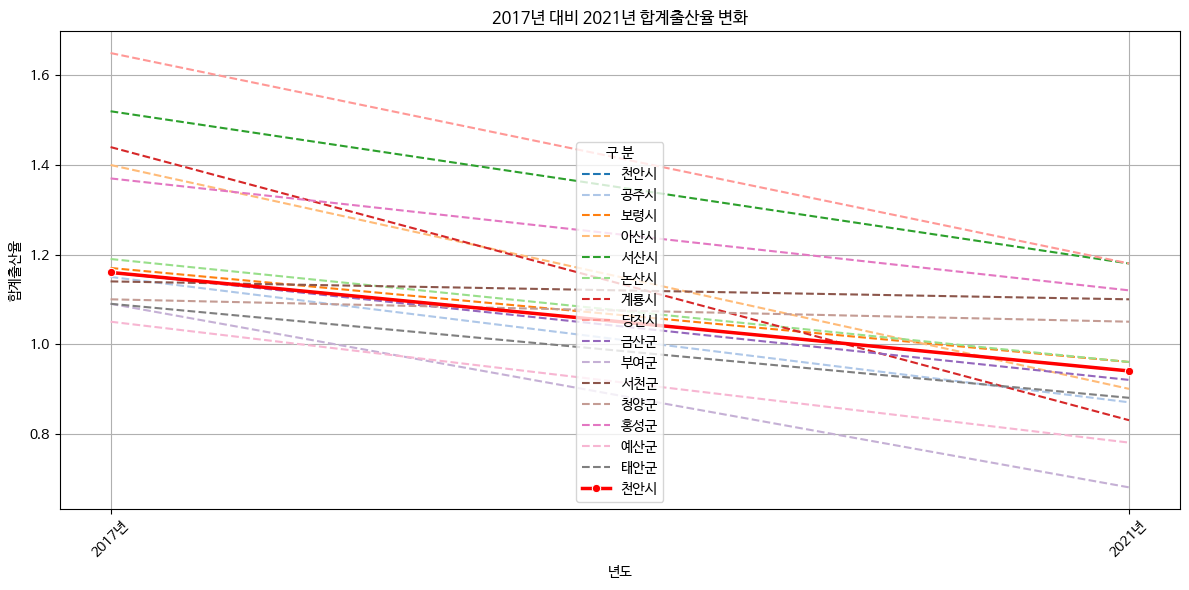

In [32]:
# 2017년 대비 2021년 충청남도 시군별 합계출산율 변화 선그래프 그리기

# '천안시' 데이터 필터링
df_chunan = df_birthrate_CC[df_birthrate_CC['구 분'] == '천안시']

# 전체 데이터에서 2017년과 2021년 데이터만 사용
df_melted = df_birthrate_CC.melt(id_vars='구 분', value_vars=['2017년', '2021년'], var_name='년도', value_name='합계출산율')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='년도', y='합계출산율', hue='구 분', palette='tab20', linestyle='--', markers=True)

# '천안시' 데이터 강조
sns.lineplot(data=df_chunan.melt(id_vars='구 분', value_vars=['2017년', '2021년'], var_name='년도', value_name='합계출산율'),
             x='년도', y='합계출산율', color='red', linewidth=2.5, marker='o', label='천안시')

plt.title('2017년 대비 2021년 합계출산율 변화')
plt.xlabel('년도')
plt.ylabel('합계출산율')
plt.legend(title='구 분')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

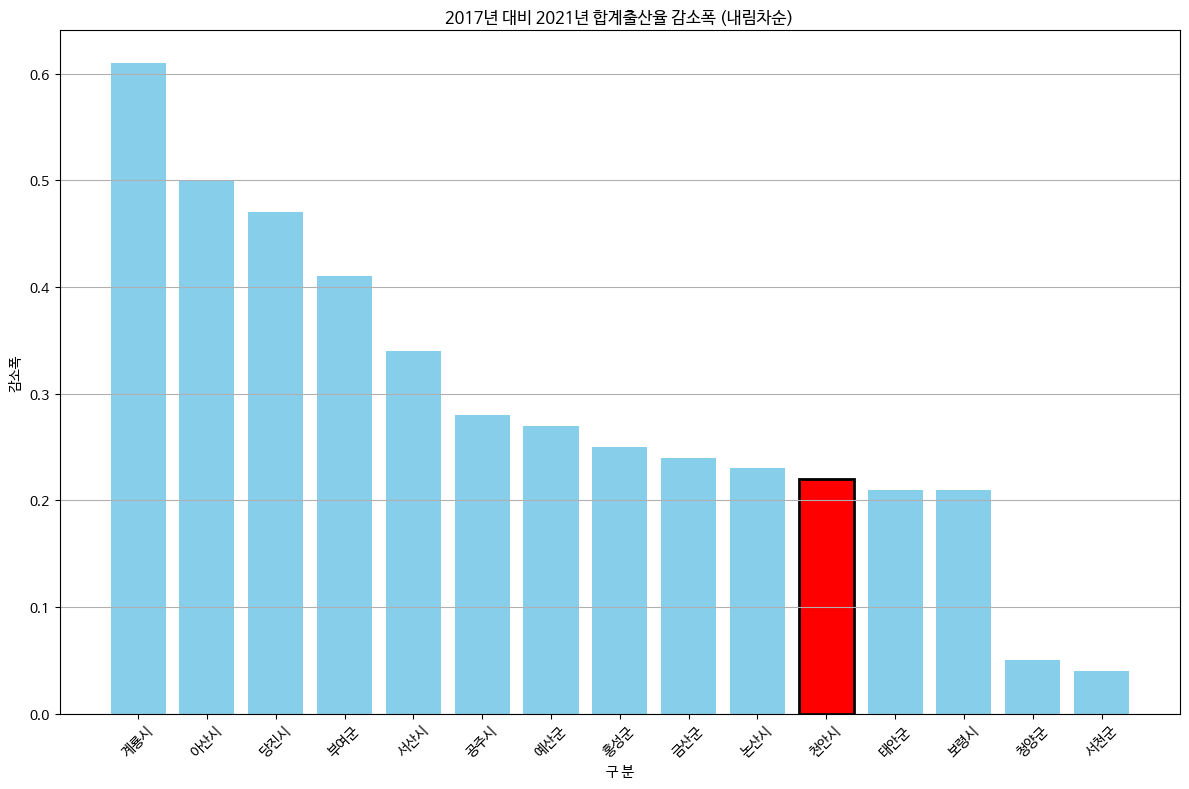

In [33]:
# 2017년 대비 2021년 합계출산율 충청남도 각 시군별 감소폭 비교

df_birthrate_CC['감소폭'] = df_birthrate_CC['2017년'] - df_birthrate_CC['2021년']

# 감소폭을 내림차순으로 정렬
df_sorted = df_birthrate_CC.sort_values(by='감소폭', ascending=False)

# 그래프 그리기
plt.figure(figsize=(12, 8))
bars = plt.bar(df_sorted['구 분'], df_sorted['감소폭'], color=['red' if x == '천안시' else 'skyblue' for x in df_sorted['구 분']])
plt.xlabel('구 분')
plt.ylabel('감소폭')
plt.title('2017년 대비 2021년 합계출산율 감소폭 (내림차순)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# '천안시' 강조
bars[df_sorted['구 분'].tolist().index('천안시')].set_edgecolor('black')
bars[df_sorted['구 분'].tolist().index('천안시')].set_linewidth(2)

plt.tight_layout()
plt.show()

<ipython-input-34-e5e4a2b5159e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')


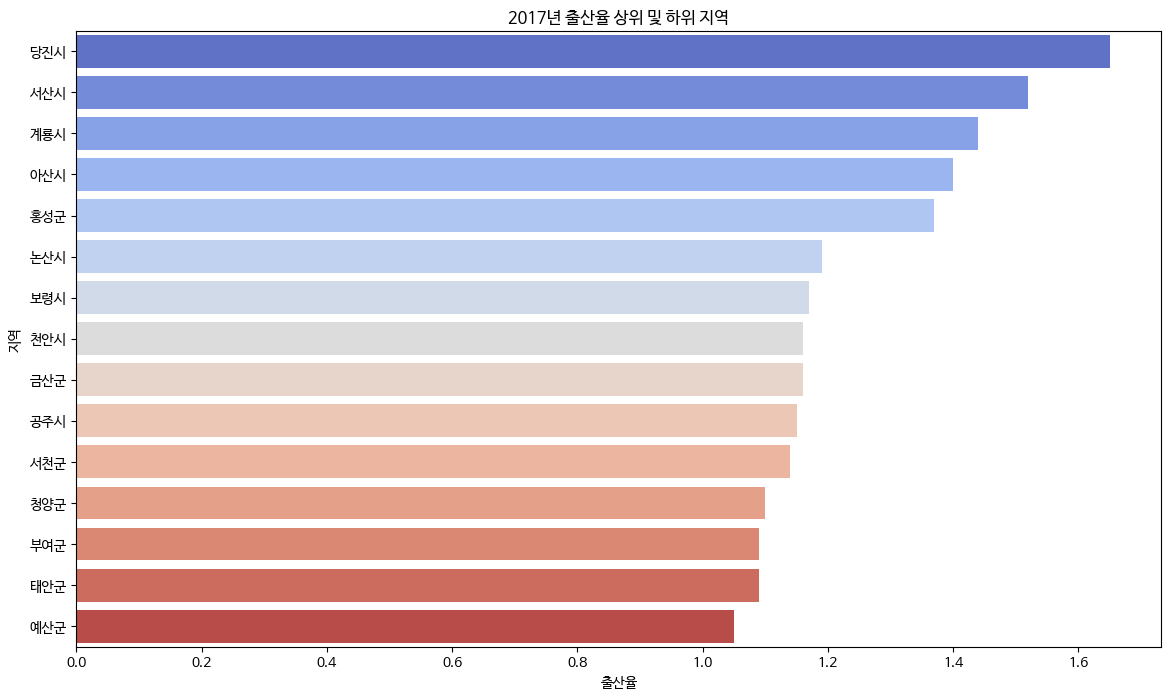

<ipython-input-34-e5e4a2b5159e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')


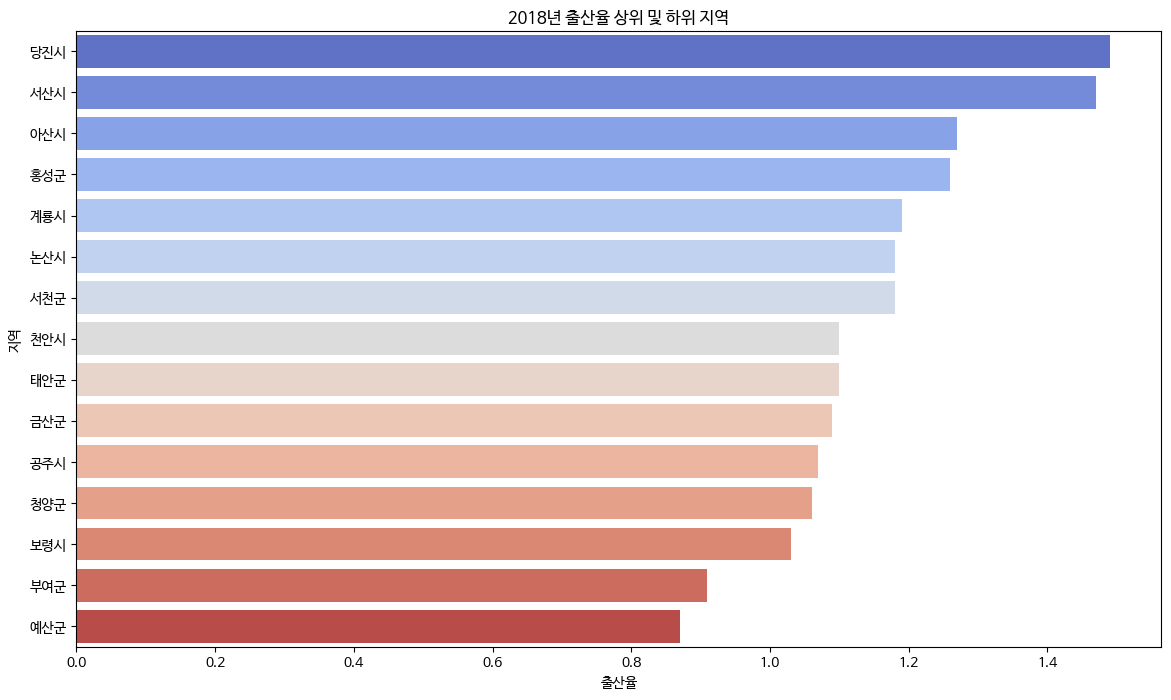

<ipython-input-34-e5e4a2b5159e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')


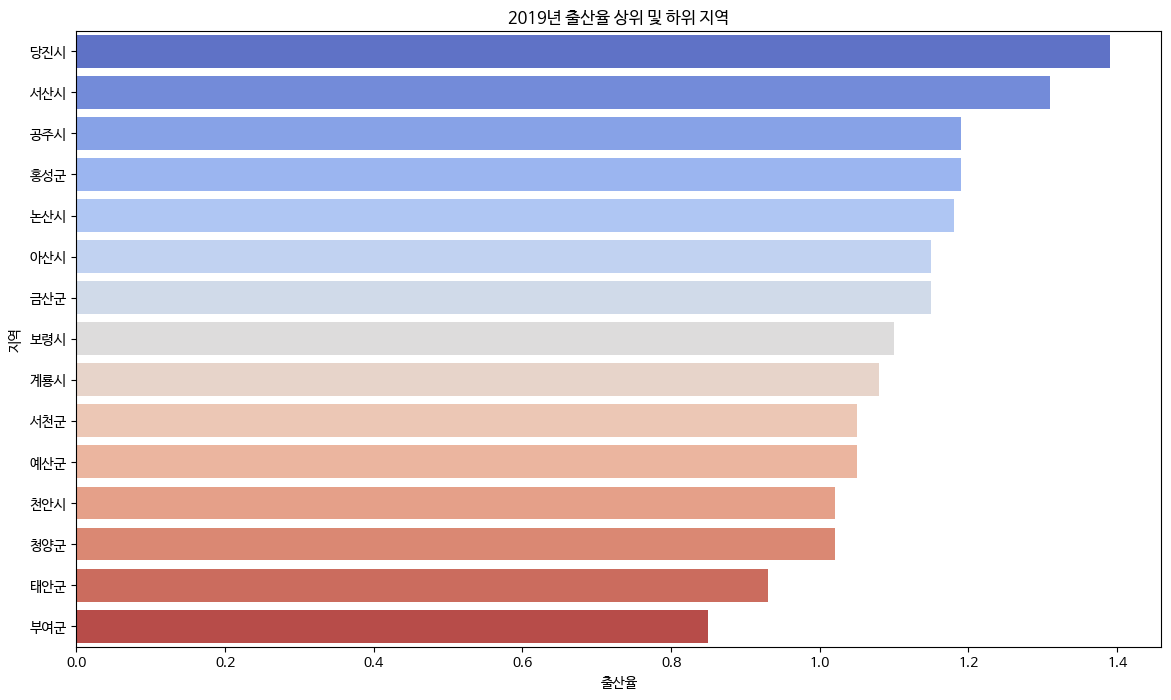

<ipython-input-34-e5e4a2b5159e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')


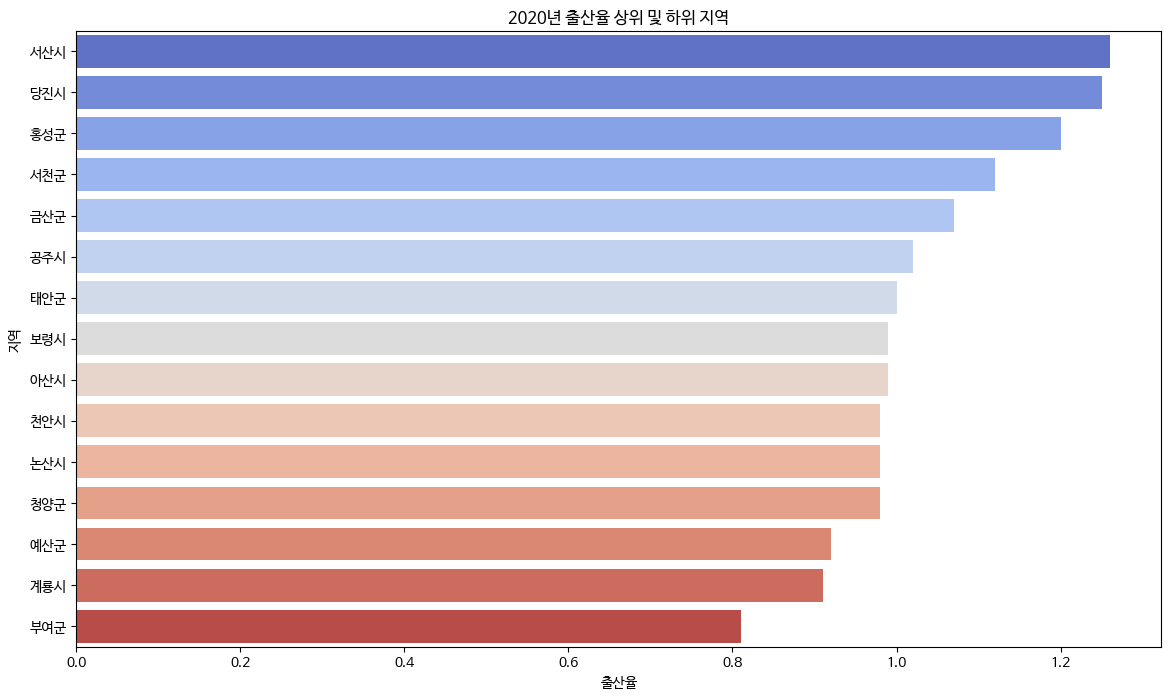

<ipython-input-34-e5e4a2b5159e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')


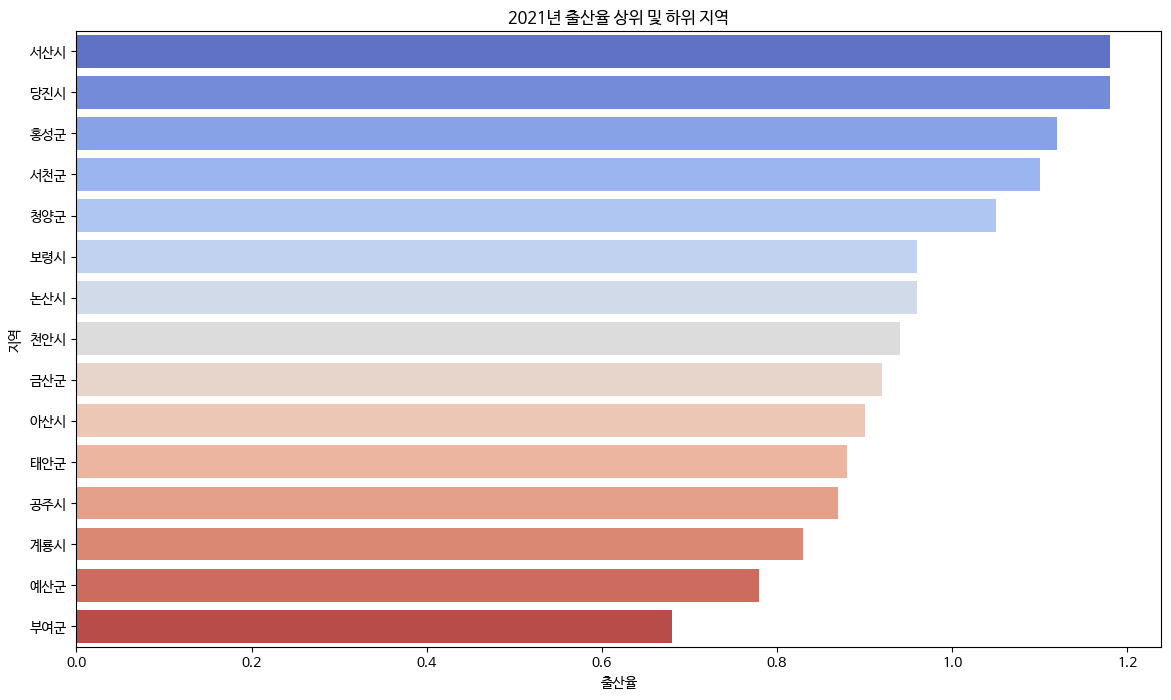

In [34]:
# 연도별 출산율을 기준으로 시각화
years = ['2017년', '2018년', '2019년', '2020년', '2021년']

for year in years:
    df_sorted_year = df_birthrate_CC[['구 분', year]].sort_values(by=year, ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=year, y='구 분', data=df_sorted_year, palette='coolwarm')
    plt.title(f'{year} 출산율 상위 및 하위 지역')
    plt.xlabel('출산율')
    plt.ylabel('지역')
    plt.show()